In [16]:
import os
import math
import random
import pickle
from collections import deque, namedtuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange


## 1.Load data

In [17]:
DATA_DIR = Path("C:/Users/HP ZBook 15/.cache/kagglehub/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1/")  # change to your local path

def find_transaction_file(data_dir):
    candidates = [
        "transaction_data.csv", "transactions.csv", "transaction.csv",
        "transaction_data.csv.gz"
    ]
    for fn in candidates:
        p = data_dir / fn
        if p.exists():
            return p
    # fallback: first csv with 'trans' in name
    for p in data_dir.glob("*.csv"):
        if 'trans' in p.name.lower():
            return p
    raise FileNotFoundError("Transaction CSV not found in " + str(data_dir))

print("Looking for transaction file in:", DATA_DIR)

Looking for transaction file in: C:\Users\HP ZBook 15\.cache\kagglehub\datasets\frtgnn\dunnhumby-the-complete-journey\versions\1


In [18]:
# Basic EDA function
def quick_eda(trans_df, product_col='product_id'):
    print("Rows:", len(trans_df))
    print("Columns:", trans_df.columns.tolist())
    if product_col in trans_df.columns:
        print("Unique SKUs:", trans_df[product_col].nunique())
    print(trans_df.head())

# -----------------------------
# 2) Prepare weekly pivot demand
# -----------------------------

def detect_time_col(df):
    for col in df.columns:
        lc = col.lower()
        if 'week' in lc and ('no' in lc or 'number' in lc or lc=='week' or 'week_no' in lc):
            return col, 'week'
        if lc in ('date','trans_date','transaction_date','t_date'):
            return col, 'date'
        if 'day' in lc:
            return col, 'date'
    # fallback try parse
    for col in df.columns:
        try:
            pd.to_datetime(df[col].iloc[:20])
            return col, 'date'
        except Exception:
            continue
    return None, None


def build_weekly_pivot(trans_df, product_col='PRODUCT_ID'):
    # detect qty col
    qty_candidates = ['quantity','qty','units','sales_qty','quantity_purchased','quantity_sold']
    qty_col = None
    for c in qty_candidates:
        if c in trans_df.columns:
            qty_col = c
            break
    if qty_col is None:
        for c in trans_df.columns:
            if 'qty' in c.lower() or 'quantity' in c.lower() or 'units' in c.lower():
                qty_col = c
                break
    if qty_col is None:
        raise ValueError('Quantity column not found')

    time_col, ttype = detect_time_col(trans_df)
    if time_col is None:
        raise ValueError('Time column not detected')

    df = trans_df.copy()
    if ttype == 'date':
        df[time_col] = pd.to_datetime(df[time_col])
        df['week'] = df[time_col].dt.to_period('W').apply(lambda r: r.start_time)
    else:
        df['week'] = df[time_col]

    # aggregate
    agg = df.groupby(['week', product_col])[qty_col].sum().reset_index()
    pivot = agg.pivot(index='week', columns=product_col, values=qty_col).fillna(0).sort_index()
    return pivot

# -----------------------------
# 3) Select top-K SKUs
# -----------------------------

def select_topk(pivot_df, k=200):
    totals = pivot_df.sum(axis=0).sort_values(ascending=False)
    topk = totals.iloc[:k].index.tolist()
    return pivot_df[topk].astype(int)

## 2.Khởi tạo môi trường

In [19]:
class MultiSKUInventoryEnvFromData:
    def __init__(self, demand_matrix, weeks, lead_time=2, horizon_weeks=12, promo_matrix=None):
        self.demand_matrix = np.asarray(demand_matrix, dtype=float)  # shape (n_weeks, n_skus)
        self.weeks = weeks
        self.n_weeks, self.n_skus = self.demand_matrix.shape
        self.lead_time = lead_time
        self.horizon = horizon_weeks
        self.promo_matrix = promo_matrix if promo_matrix is not None else np.zeros_like(self.demand_matrix, dtype=int)
        self.mu = np.maximum(0.001, np.mean(self.demand_matrix, axis=0))
        self.sigma = np.sqrt(np.maximum(1e-6, self.mu))
        self.reset(start_week_idx=0)

    def reset(self, start_week_idx=0):
        self.start_week = start_week_idx % self.n_weeks
        self.week_cursor = self.start_week
        self.I = np.maximum(0, np.round(1.5 * self.mu * self.lead_time).astype(int))
        self.oo = np.zeros((self.n_skus, self.lead_time), dtype=int)
        self.backlog = np.zeros(self.n_skus, dtype=int)
        self.t = 0
        self.promo = self.promo_matrix[self.week_cursor] if self.promo_matrix is not None else np.zeros(self.n_skus, dtype=int)
        return self._get_full_state()

    def step(self, orders, stochastic=False, promo_boost=0.2):
        assert len(orders) == self.n_skus
        holding_cost_per_unit = 0.01
        stockout_cost_per_unit = 1.0
        order_fixed_cost = 0.5
        order_unit_cost = 0.0

        # place orders into last bucket
        self.oo[:, -1] += orders

        hist = self.demand_matrix[self.week_cursor]
        if stochastic:
            lam = np.clip(hist, 0, 1e8)
            demand = np.random.poisson(lam).astype(int)
        else:
            demand = np.round(hist).astype(int)

        promo_flags = self.promo_matrix[self.week_cursor] if self.promo_matrix is not None else np.zeros_like(demand)
        demand = (demand * (1 + promo_boost * promo_flags)).astype(int)

        # serve demand per SKU
        available = self.I.copy()
        # served = min(available, demand + backlog)
        served = np.minimum(available, demand + self.backlog)
        serve_backlog = np.minimum(self.backlog, served)
        self.backlog -= serve_backlog
        served_new = served - serve_backlog
        unfilled = (demand - served_new)
        self.backlog += np.maximum(0, unfilled)
        self.I -= (served_new + serve_backlog)

        # per-sku costs
        holding_cost_vec = holding_cost_per_unit * self.I
        stockout_cost_vec = stockout_cost_per_unit * self.backlog
        order_cost_vec = order_fixed_cost * (orders > 0).astype(float) + order_unit_cost * orders
        reward_per_sku = -(holding_cost_vec + stockout_cost_vec + order_cost_vec)

        # arrivals shift
        arrivals = self.oo[:, 0].copy()
        if self.lead_time > 1:
            self.oo[:, :-1] = self.oo[:, 1:]
        self.oo[:, -1] = 0
        self.I += arrivals

        # advance week pointer
        self.week_cursor = (self.week_cursor + 1) % self.n_weeks
        self.promo = self.promo_matrix[self.week_cursor] if self.promo_matrix is not None else np.zeros(self.n_skus, dtype=int)
        self.t += 1
        done = (self.t >= self.horizon)

        # return full-state, reward_per_sku (vector), done
        total_reward = float(reward_per_sku.sum())
        return self._get_full_state(), reward_per_sku, done, {"demand": demand, "arrivals": arrivals, "total_reward": total_reward}

    def _get_full_state(self):
        return {
            'I': self.I.copy(),
            'oo': self.oo.copy(),
            'backlog': self.backlog.copy(),
            'promo': self.promo.copy(),
            'mu': self.mu.copy(),
            'sigma': self.sigma.copy(),
            't': self.t,
            'week': self.week_cursor
        }

In [20]:
def sku_feature_vector(state, idx, lead_time=2):
    I = float(state['I'][idx])
    oo = state['oo'][idx]
    backlog = float(state['backlog'][idx])
    promo = float(state['promo'][idx])
    mu = float(state['mu'][idx])
    sigma = float(state['sigma'][idx])
    t = state['t']

    IP = I + oo.sum() - backlog
    oo_due1 = float(oo[0]) if lead_time >= 1 else 0.0
    oo_other = float(max(0, oo.sum() - oo_due1))
    sigma_L = math.sqrt(max(1e-6, mu * max(1, lead_time)))

    feats = np.array([
        I / sigma_L,
        IP / sigma_L,
        oo_due1 / sigma_L,
        oo_other / sigma_L,
        backlog / sigma_L,
        mu / sigma_L,
        sigma / sigma_L,
        math.sin(2*math.pi*((t % 7)/7)),
        math.cos(2*math.pi*((t % 7)/7)),
        promo
    ], dtype=np.float32)
    return feats

## Deep QLN

In [26]:
# === 2) Dueling network & Double DQN agent ===
class DuelingQNetwork(nn.Module):
    def __init__(self, input_dim, n_actions, hidden=[256,128]):
        super().__init__()
        # shared feature trunk
        layers = []
        last = input_dim
        for h in hidden:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU())
            last = h
        self.trunk = nn.Sequential(*layers)
        # value head
        self.value_head = nn.Sequential(nn.Linear(last, 64), nn.ReLU(), nn.Linear(64,1))
        # advantage head
        self.adv_head = nn.Sequential(nn.Linear(last, 64), nn.ReLU(), nn.Linear(64, n_actions))
    def forward(self, x):
        h = self.trunk(x)
        v = self.value_head(h)            # (B,1)
        a = self.adv_head(h)             # (B, n_actions)
        # Q = V + (A - mean(A))
        a_mean = a.mean(dim=1, keepdim=True)
        q = v + (a - a_mean)
        return q

In [27]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

In [28]:
class DoubleDuelingDQNAgent:
    def __init__(self, input_dim, n_actions, lr=1e-3, gamma=0.99, device='cpu'):
        self.device = device
        self.policy = DuelingQNetwork(input_dim, n_actions).to(device)
        self.target = DuelingQNetwork(input_dim, n_actions).to(device)
        self.target.load_state_dict(self.policy.state_dict())
        self.opt = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.n_actions = n_actions
        self.steps = 0

    def q_values(self, states_np):
        st = torch.tensor(states_np, dtype=torch.float32, device=self.device)
        return self.policy(st)

    def act_batch(self, state_batch, eps=0.1):
        B = state_batch.shape[0]
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions, size=B)
        st = torch.tensor(state_batch, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            q = self.policy(st).cpu().numpy()
        return np.argmax(q, axis=1)

    def update_double(self, buffer, batch_size=128, tau=0.005):
        if len(buffer) < batch_size:
            return
        tr = buffer.sample(batch_size)
        s = torch.tensor(np.stack(tr.state), dtype=torch.float32, device=self.device)
        a = torch.tensor(tr.action, dtype=torch.long, device=self.device).unsqueeze(1)
        r = torch.tensor(tr.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        s2 = torch.tensor(np.stack(tr.next_state), dtype=torch.float32, device=self.device)
        done = torch.tensor(tr.done, dtype=torch.float32, device=self.device).unsqueeze(1)

        # current Q(s,a)
        q_vals = self.policy(s).gather(1, a)

        # Double DQN target:
        # use policy to select argmax a' on next state
        with torch.no_grad():
            a_prime = torch.argmax(self.policy(s2), dim=1, keepdim=True)   # shape (B,1)
            q_next_target = self.target(s2).gather(1, a_prime)             # evaluate via target
            q_target = r + (1 - done) * self.gamma * q_next_target

        loss = nn.functional.mse_loss(q_vals, q_target)
        self.opt.zero_grad()
        loss.backward()
        # gradient clipping to stabilize
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=10.0)
        self.opt.step()

        # soft-update target
        for p, tp in zip(self.policy.parameters(), self.target.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

        self.steps += 1


# Trainng data

In [29]:
def train_double_dueling(env,
                         episodes=200,
                         action_buckets=None,
                         device='cpu'):
    if action_buckets is None:
        action_buckets = np.array([0,1,2,5,10,20,50], dtype=int)
    n_actions = len(action_buckets)
    input_dim = 10

    agent = DoubleDuelingDQNAgent(input_dim, n_actions, lr=5e-4, gamma=0.95, device=device)
    buffer = ReplayBuffer(capacity=300000)

    eps_start, eps_end = 0.6, 0.02
    eps_decay_steps = episodes * 1000  # long decay
    total_rewards = []
    avg_rewards = []

    for ep in range(episodes):
        start_week = random.randint(0, env.n_weeks - 1)
        state = env.reset(start_week_idx=start_week)
        ep_reward = 0.0
        done = False
        while not done:
            M = min(256, env.n_skus)
            skus = np.random.choice(env.n_skus, size=M, replace=False)
            feats = np.stack([sku_feature_vector(state, s, lead_time=env.lead_time) for s in skus])

            frac = min(1.0, agent.steps / max(1, eps_decay_steps))
            eps = eps_start + (eps_end - eps_start) * frac

            act_idxs = agent.act_batch(feats, eps=eps)
            orders = np.zeros(env.n_skus, dtype=int)
            for i, s in enumerate(skus):
                base = action_buckets[act_idxs[i]]
                scale = int(max(1, round(state['mu'][s] / 5.0)))
                orders[s] = int(base * scale)

            # env step returns reward_per_sku (vector)
            next_state, reward_per_sku, done, info = env.step(orders, stochastic=True)
            ep_reward += float(reward_per_sku.sum())

            # push per-sku transitions with the SKU-specific reward
            for i, s in enumerate(skus):
                st_vec = feats[i]
                act = int(act_idxs[i])
                r = float(reward_per_sku[s])   # use per-sku reward directly
                next_vec = sku_feature_vector(next_state, s, lead_time=env.lead_time)
                buffer.push(st_vec, act, r, next_vec, float(done))

            # update agent (Double Dueling)
            agent.update_double(buffer, batch_size=128, tau=0.005)
            state = next_state

        total_rewards.append(ep_reward)
        avg_rewards.append(np.mean(total_rewards[-5:]))
        if (ep+1) % 5 == 0:
            print(f"Ep {ep+1}/{episodes} - ep_reward: {ep_reward:.2f}, avg5: {avg_rewards[-1]:.2f}, eps: {eps:.3f}, buffer:{len(buffer)}")

    return agent, total_rewards, avg_rewards


def plot_rewards(total_rewards, avg_rewards=None):
    plt.figure(figsize=(10,5))
    plt.plot(total_rewards, label='Episode reward')
    if avg_rewards is not None:
        plt.plot(avg_rewards, label='Moving average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.title('Learning curve - DQN Inventory Agent (data-driven)')
    plt.legend()
    plt.grid(True)
    plt.show()

Using C:\Users\HP ZBook 15\.cache\kagglehub\datasets\frtgnn\dunnhumby-the-complete-journey\versions\1\transaction_data.csv
Building weekly pivot...
Pivot shape (weeks x skus): (1, 92339)
Selected topk shape: (1, 100)
Ep 5/500 - ep_reward: -280650540.84, avg5: -340470408.94, eps: 0.600, buffer:6000
Ep 10/500 - ep_reward: -627432784.03, avg5: -688958494.14, eps: 0.600, buffer:12000
Ep 15/500 - ep_reward: -484581282.53, avg5: -585194907.11, eps: 0.600, buffer:18000
Ep 20/500 - ep_reward: -216439436.02, avg5: -404588611.38, eps: 0.600, buffer:24000
Ep 25/500 - ep_reward: -231913558.34, avg5: -332256180.67, eps: 0.600, buffer:30000
Ep 30/500 - ep_reward: -1125035498.33, avg5: -689592522.00, eps: 0.600, buffer:36000
Ep 35/500 - ep_reward: -535149613.45, avg5: -473583746.30, eps: 0.600, buffer:42000
Ep 40/500 - ep_reward: -389260352.12, avg5: -342971760.31, eps: 0.599, buffer:48000
Ep 45/500 - ep_reward: -230131027.37, avg5: -422496565.07, eps: 0.599, buffer:54000
Ep 50/500 - ep_reward: -2731

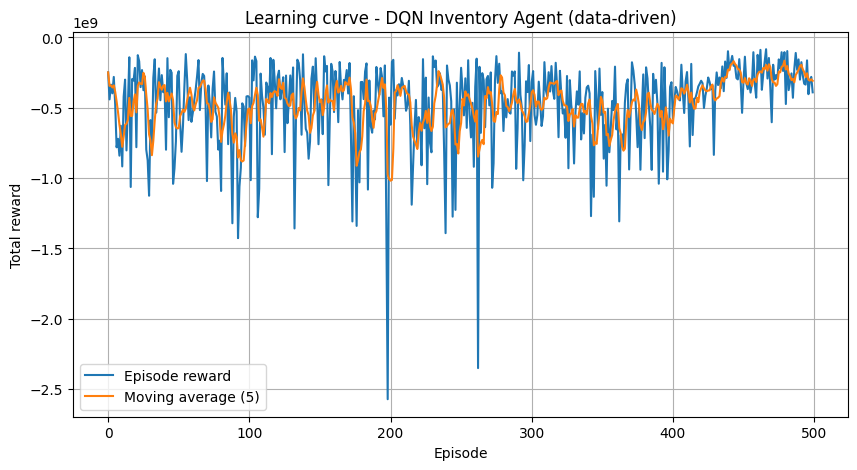

Done. Models saved in ./models


In [32]:
 # 1. Load transactions (adjust path)
tx_file = find_transaction_file(DATA_DIR)
print('Using', tx_file)
tx = pd.read_csv(tx_file, low_memory=False)

# Quick EDA quick_eda(tx)

# 2. Build weekly pivot
print('Building weekly pivot...')
pivot = build_weekly_pivot(tx, product_col='PRODUCT_ID')
print('Pivot shape (weeks x skus):', pivot.shape)

# 3. Select top-200 SKUs
topk_df = select_topk(pivot, k=100)
print('Selected topk shape:', topk_df.shape)

# 4. Build env
demand_matrix = topk_df.values  # (n_weeks, 200)
weeks = list(topk_df.index)
env = MultiSKUInventoryEnvFromData(demand_matrix, weeks, lead_time=2, horizon_weeks=12)
# 5. Train small DQN
agent, total_rewards, avg_rewards = train_double_dueling(env, episodes=500, action_buckets=[0,1,2,5,10,20,50], device='cpu')

# 6. Plot
plot_rewards(total_rewards, avg_rewards)

# Save agent policy
os.makedirs('models', exist_ok=True)
torch.save(agent.policy.state_dict(), 'models/dqn_policy_data.pth')
with open('models/rewards.pkl', 'wb') as f:
    pickle.dump({'rewards': total_rewards, 'avg': avg_rewards}, f)

print('Done. Models saved in ./models')
